In [1]:
import glob
import gzip
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import stats
import sys

from Bio.Seq import Seq
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as offline
import seaborn as sns

import matrix_transform
import visualize

%matplotlib inline
sns.set(font="Arial")
sns.set_theme(style="ticks")
colors = ['#D81B60', '#1E88E5', '#FFC107', '#31B547']
sns.set_palette(sns.color_palette(colors))

In [69]:
fig_folder = 'Figures/'
sample_dir = 'sample_spreadsheet_031521.csv'
samples = pd.read_csv(sample_dir, comment = '#')

amino_acid_list = ['*', 'A', 'C', 'D', 'E', 'F', 'G', 'H',
                   'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
                   'S', 'T', 'V', 'W', 'Y']
amino_acid_list.reverse()
grouped_aa = ['H', 'K','R','D','E','C','M','N','Q','S','T','A',\
             'I','L','V','F','W','Y','G','P','*']

wt_ = ('SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDM'
       'LNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTP'
       'KYKFVRIQPGQTFSVLFLNGSCGSVG'
       'FNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTT'
       'ITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDI'
       'LGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ*')
wt_full = ('MSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICT'
           'SEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKV'
           'DTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIK'
           'GSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYG'
           'PFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLND'
           'FNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNG'
           'MNGRTILGSALLEDEFTPFDVVRQCSGVTFQ')
wt_ = [x for x in wt_]
wt_full = [x for x in wt_full]

sets = [1, 2, 3, 4, 5, 6, 7,8, 9, 10, 11, 12, 13,\
        14, 15, 16, 17, 18, 19, 20, 'R1']
set21 = [21]
res_redo = ['8R', '13R1', '13R2', '14R', '16R', ]
#            '9R1', '9R2', '10R1', '10R2']

all_sets = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 
        17, 18, 19, 20, 21, 8, 9, 10, 'R1',
       '8R', '13R1', '13R2', '14R', '16R',
        '9R1', '9R2', '10R1', '10R2']

## Activity

### Visualize the raw distributions for each individual set

In [70]:
subplot_titles = [
        "Set 1", "Set 2", "Set 3", "Set 4",\
        "Set 5", "Set 6", "Set 7", "Set 8", "Set 9", "Set 10",\
        "Set 11", "Set 12", "Set 13",\
        "Set 14", "Set 15", "Set 16", "Set 17",\
        "Set 18", "Set 19", "Set 20", "Set 21",
        "Set R1", \
        "Set 8R", "Set 13R1", "Set 13R2", "Set 14R", "Set 16R"]
matrix_transform.original_dist(
        'new_glu_gal', 'gal_glu.csv', subplot_titles, samples,\
        sets, res_redo, all_sets,\
        title = 'Raw distributions of foldchange over wildtype in gal/glu')

### Stop codon to -1 and wt set to 0 for each set

In [71]:
subplot_titles = [
        "Set 1", "Set 2", "Set 3", "Set 4",\
        "Set 5", "Set 6", "Set 7", "Set 8", "Set 9", "Set 10",\
        "Set 11", "Set 12", "Set 13",\
        "Set 14", "Set 15", "Set 16", "Set 17",\
        "Set 18", "Set 19", "Set 20", "Set 21",
        "Set R1", \
        "Set 8R", "Set 13R1", "Set 13R2", "Set 14R", "Set 16R"]
matrix_transform.transform_dist(
        'new_glu_gal', 'gal_glu.csv', subplot_titles, samples,\
        sets, res_redo, all_sets, set21, \
        title = 'Raw distributions of foldchange over wildtype in gal/glu')

### Make heatmap of transformed data

In [98]:
all_residues = matrix_transform.transform_matrix(
    'new_glu_gal', 'gal_glu.csv', samples, sets, res_redo, all_sets, set21)

all_residues.to_csv('CSVs/glu_gal_WT_stop_normalize.csv')
visualize.make_heatmap(
        all_residues, [int(x[4:]) for x in list(all_residues.columns)], 
         grouped_aa, wt_full[1:], show = True, save = False, 
         name = fig_folder + 'Fig2_glu_gal_wt_STOP_normalize')

In [99]:
wt = wt_full[1:]
visualize.make_heatmap_vert(all_residues.reindex(grouped_aa).transpose(), 
                            wt, show = False, save = False, 
                            name = fig_folder + 'Fig2_glu_gal_wt_STOP_normalize_vert')

### Add RSA info, secondary structure, and patient mutations

In [100]:
# import broad gisaid data
single_muts = 'CSVs/Residue_permissible_variants.csv'
single_muts = pd.read_csv(single_muts)
single_muts['residue'] = single_muts['residue']
single_muts = single_muts.melt(id_vars = 'residue').dropna()
rsa = pd.read_csv('CSVs/dimer_dssp_processed.csv')
SS_dict = {'loop':0, 'helix':-1, 'strand':1}
rsa['SS_num'] = rsa['SS_class'].map(SS_dict)

In [102]:
visualize.heatmap_rsa_vert(all_residues.reindex(grouped_aa).transpose(),
                        single_muts['residue'],
                        grouped_aa, rsa, single_muts['value'], 
                        all_residues.drop('*').mean(), 
                        show = False, 
                        save = False,
                        name = fig_folder + 'Fig2_glu_gal_wt_STOP_normalize_w_RSA_SS_average_vert')

In [103]:
x_ = [int(x[4:]) for x in list(all_residues.columns)]
y_ = all_residues.reindex(grouped_aa)
visualize.heatmap_rsa(all_residues, x_, y_, single_muts['residue'],
                    grouped_aa, rsa, single_muts['value'], show = True, 
                    save = False, 
                    name = fig_folder + 'Fig2_glu_gal_wt_STOP_normalize_w_RSA_SS_average')

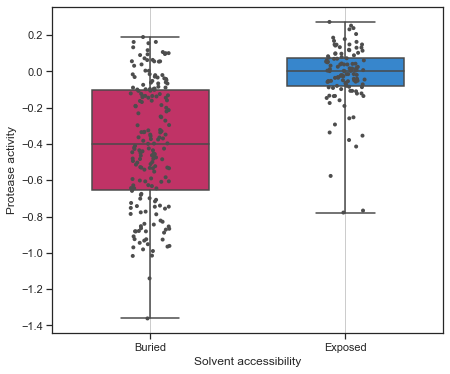

In [104]:
rsa['Solvent accessibility'] = ['Buried' if x < 0.25 else 'Exposed' for x in rsa['RSA']]
rsa['Protease activity'] = list(all_residues.iloc[::-1].mean())

sns.set(font="Arial")
sns.set_theme(style="ticks")

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with vertical boxes
sns_plot = sns.boxplot(x="Solvent accessibility", y="Protease activity", data=rsa,
            whis=[0, 100], width=.6, palette=sns.color_palette(colors))

# Add in points to show each observation
sns.stripplot(x="Solvent accessibility", y="Protease activity", data=rsa,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
fig = sns_plot.get_figure()
# fig.savefig(fig_folder+"Fig2_RSA_activity.png", dpi=400)

### Map patient mutations onto active variants

In [105]:
# activity values of all variants in heatmap
flat = [item for sublist in all_residues.values for item in sublist]
flat = [x for x in flat if str(x) != 'nan']

# find activity of mutant proteases identified in clinical variants
pat_vars = []
for ind, row in single_muts.iterrows():
    pat_vars.append(all_residues['Res '+str(row['residue'])].loc[row['value']])

In [106]:
# Visualize the distribution of the relative fitnesses
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Histogram(x=flat, 
                           opacity=0.75, marker_color = '#D81B60', name='All residues',
                           xbins=dict( # bins used for histogram
                            size=0.075
                        )),
             secondary_y=False)

fig.add_trace(go.Histogram(x=pat_vars,opacity=0.75, marker_color = '#1E88E5',
                           name='Clinical isolates',
                          xbins=dict( # bins used for histogram
                            size=0.075
                        )),
              secondary_y=True)

fig.update_yaxes(title_text="Number (all residues)", secondary_y=False)
fig.update_yaxes(title_text="Number (clinical isolates)", secondary_y=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(
    title="Protease activity",
    xaxis_title="Activity score",
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    font=dict(family="Arial",
                    size=16)
    
    )
fig.show()
# fig.write_image(fig_folder+"Fig2_activity_all_and_clinical.pdf")

In [107]:
len(pat_vars)

435

In [83]:
# activity values of all variants in heatmap
flat = [item for sublist in all_residues.values for item in sublist]
flat = [x for x in flat if str(x) != 'nan']

# find activity of mutant proteases identified in clinical variants
wt_vals = []
for ind, row in enumerate(wt_full[1:]):
    wt_vals.append(all_residues['Res '+str(ind+1)].loc[row])

In [84]:
# Visualize the distribution of the relative fitnesses
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Histogram(x=flat, 
                           opacity=0.75, marker_color = '#D81B60', name='All residues',
                           xbins=dict( # bins used for histogram
                            size=0.075
                        )),
             secondary_y=False)

fig.add_trace(go.Histogram(x=wt_vals,opacity=0.75, marker_color = '#1E88E5',
                           name='WT',
                          xbins=dict( # bins used for histogram
                            size=0.075
                        )),
              secondary_y=True)

fig.update_yaxes(title_text="Number (all residues)", secondary_y=False)
fig.update_yaxes(title_text="Number (clinical isolates)", secondary_y=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(
    title="Protease activity",
    xaxis_title="Activity score",
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    font=dict(family="Arial",
                    size=16)
    
    )
fig.show()
# fig.write_image(fig_folder+"Fig2_activity_all_and_clinical.pdf")

In [85]:
print(np.mean(wt_vals), np.std(wt_vals))

0.0013965341654194794 0.11169378302064124


### Threshold 100_30

In [94]:
all_residues = matrix_transform.transform_matrix(
    'glu_gal_100_30', 'gal_glu.csv', samples, sets, res_redo, all_sets, set21)

all_residues.to_csv('CSVs/glu_gal_WT_stop_normalize.csv')
visualize.make_heatmap(
        all_residues, [int(x[4:]) for x in list(all_residues.columns)], 
         grouped_aa, wt_full[1:], show = True, save = False, 
         name = fig_folder + 'Fig2_glu_gal_wt_STOP_normalize')

In [95]:
# activity values of all variants in heatmap
flat = [item for sublist in all_residues.values for item in sublist]
flat = [x for x in flat if str(x) != 'nan']

# find activity of mutant proteases identified in clinical variants
pat_vars = []
for ind, row in single_muts.iterrows():
    pat_vars.append(all_residues['Res '+str(row['residue'])].loc[row['value']])

In [96]:
# Visualize the distribution of the relative fitnesses
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Histogram(x=flat, 
                           opacity=0.75, marker_color = '#D81B60', name='All residues',
                           xbins=dict( # bins used for histogram
                            size=0.075
                        )),
             secondary_y=False)

fig.add_trace(go.Histogram(x=pat_vars,opacity=0.75, marker_color = '#1E88E5',
                           name='Clinical isolates',
                          xbins=dict( # bins used for histogram
                            size=0.075
                        )),
              secondary_y=True)

fig.update_yaxes(title_text="Number (all residues)", secondary_y=False)
fig.update_yaxes(title_text="Number (clinical isolates)", secondary_y=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(
    title="Protease activity",
    xaxis_title="Activity score",
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    font=dict(family="Arial",
                    size=16)
    
    )
fig.show()
# fig.write_image(fig_folder+"Fig2_activity_all_and_clinical.pdf")

In [97]:
len(pat_vars)

435

In [54]:
# activity values of all variants in heatmap
flat = [item for sublist in all_residues.values for item in sublist]
flat = [x for x in flat if str(x) != 'nan']

# find activity of mutant proteases identified in clinical variants
wt_vals = []
for ind, row in enumerate(wt_full[1:]):
    wt_vals.append(all_residues['Res '+str(ind+1)].loc[row])

In [55]:
# Visualize the distribution of the relative fitnesses
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Histogram(x=flat, 
                           opacity=0.75, marker_color = '#D81B60', name='All residues',
                           xbins=dict( # bins used for histogram
                            size=0.075
                        )),
             secondary_y=False)

fig.add_trace(go.Histogram(x=wt_vals,opacity=0.75, marker_color = '#1E88E5',
                           name='WT',
                          xbins=dict( # bins used for histogram
                            size=0.075
                        )),
              secondary_y=True)

fig.update_yaxes(title_text="Number (all residues)", secondary_y=False)
fig.update_yaxes(title_text="Number (clinical isolates)", secondary_y=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(
    title="Protease activity",
    xaxis_title="Activity score",
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    font=dict(family="Arial",
                    size=16)
    
    )
fig.show()
# fig.write_image(fig_folder+"Fig2_activity_all_and_clinical.pdf")

In [56]:
print(np.mean(wt_vals), np.std(wt_vals))

0.0019943609791652547 0.08727071666949829


### Threshold 500_30

In [63]:
all_residues = matrix_transform.transform_matrix(
    'glu_gal_500_30', 'gal_glu.csv', samples, sets, res_redo, all_sets, set21)

all_residues.to_csv('CSVs/glu_gal_WT_stop_normalize.csv')
visualize.make_heatmap(
        all_residues, [int(x[4:]) for x in list(all_residues.columns)], 
         grouped_aa, wt_full[1:], show = True, save = False, 
         name = fig_folder + 'Fig2_glu_gal_wt_STOP_normalize')

In [64]:
# activity values of all variants in heatmap
flat = [item for sublist in all_residues.values for item in sublist]
flat = [x for x in flat if str(x) != 'nan']

# find activity of mutant proteases identified in clinical variants
pat_vars = []
for ind, row in single_muts.iterrows():
    pat_vars.append(all_residues['Res '+str(row['residue'])].loc[row['value']])

In [65]:
# Visualize the distribution of the relative fitnesses
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Histogram(x=flat, 
                           opacity=0.75, marker_color = '#D81B60', name='All residues',
                           xbins=dict( # bins used for histogram
                            size=0.075
                        )),
             secondary_y=False)

fig.add_trace(go.Histogram(x=pat_vars,opacity=0.75, marker_color = '#1E88E5',
                           name='Clinical isolates',
                          xbins=dict( # bins used for histogram
                            size=0.075
                        )),
              secondary_y=True)

fig.update_yaxes(title_text="Number (all residues)", secondary_y=False)
fig.update_yaxes(title_text="Number (clinical isolates)", secondary_y=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(
    title="Protease activity",
    xaxis_title="Activity score",
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    font=dict(family="Arial",
                    size=16)
    
    )
fig.show()
# fig.write_image(fig_folder+"Fig2_activity_all_and_clinical.pdf")

In [66]:
# activity values of all variants in heatmap
flat = [item for sublist in all_residues.values for item in sublist]
flat = [x for x in flat if str(x) != 'nan']

# find activity of mutant proteases identified in clinical variants
wt_vals = []
for ind, row in enumerate(wt_full[1:]):
    wt_vals.append(all_residues['Res '+str(ind+1)].loc[row])

In [67]:
# Visualize the distribution of the relative fitnesses
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Histogram(x=flat, 
                           opacity=0.75, marker_color = '#D81B60', name='All residues',
                           xbins=dict( # bins used for histogram
                            size=0.075
                        )),
             secondary_y=False)

fig.add_trace(go.Histogram(x=wt_vals,opacity=0.75, marker_color = '#1E88E5',
                           name='WT',
                          xbins=dict( # bins used for histogram
                            size=0.075
                        )),
              secondary_y=True)

fig.update_yaxes(title_text="Number (all residues)", secondary_y=False)
fig.update_yaxes(title_text="Number (clinical isolates)", secondary_y=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(
    title="Protease activity",
    xaxis_title="Activity score",
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    font=dict(family="Arial",
                    size=16)
    
    )
fig.show()
# fig.write_image(fig_folder+"Fig2_activity_all_and_clinical.pdf")

In [68]:
print(np.mean(wt_vals), np.std(wt_vals))

0.0003894809629972354 0.10373023911288193
